## Coursera IBM Data Science Capstone Project

### Segmenting and Clustering Neighborhoods in New York City
##### Feburary 2020

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# handle JSON files
import json

# transform JSON file into a pandas dataframe
from pandas.io.json import json_normalize

# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim

import requests
import urllib.request
import time

# map rendering
import folium

### Preparing the Neighborhoods Data for NYC

In [2]:
# load the json file
with open('/Users/hahatrisha/Downloads/NewYork_geodata.json') as nyc_json_data:
    nyc_data = json.load(nyc_json_data)

nyc_data['features'][0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [3]:
len(nyc_data['features'])

306

In [4]:
# transform into pandas dataframe
column_names = ['Borough', 'Neighbourhood', 'Latitude', 'Longitude']
neighbourhoods_NYC = pd.DataFrame(columns=column_names)

for n in range(0, len(nyc_data['features'])):
    borough = nyc_data['features'][n]['properties']['borough']
    neighbourhood_name = nyc_data['features'][n]['properties']['name']
    neighbourhood_loc = nyc_data['features'][n]['geometry']['coordinates']
    lat = neighbourhood_loc[1]
    lng = neighbourhood_loc[0]
    
    neighbourhoods_NYC = neighbourhoods_NYC.append({'Borough': borough,
                                                  'Neighbourhood': neighbourhood_name,
                                                  'Latitude': lat,
                                                  'Longitude': lng},
                                                  ignore_index = True)
neighbourhoods_NYC.head(3)

,Borough,Neighbourhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806


In [5]:
print("The New York City has {} boroughs and {} neighbourhoods."
      .format(len(neighbourhoods_NYC['Borough'].unique()),neighbourhoods_NYC.shape[0]))

The New York City has 5 boroughs and 306 neighbourhoods.


There is one issue with the current dataframe: some neighbourhoods share the same name but locate in different boroughs. To deal with it, we will include the borough name in the name of the neighbourhoods.

In [6]:
# find neighbourhoods sharing the same name
nn = neighbourhoods_NYC['Neighbourhood'].value_counts()
print(nn[nn>1])

nn_index = nn[nn>1].index.tolist()
nn_index

Chelsea        2
Bay Terrace    2
Sunnyside      2
Murray Hill    2
Name: Neighbourhood, dtype: int64


['Chelsea', 'Bay Terrace', 'Sunnyside', 'Murray Hill']

In [7]:
dup_neighbourhood = []
for n in nn_index:
    dup_neighbourhood.append([neighbourhoods_NYC[neighbourhoods_NYC['Neighbourhood']==n]])
dup_neighbourhood

[[           Borough Neighbourhood   Latitude  Longitude
  116      Manhattan       Chelsea  40.744035 -74.003116
  244  Staten Island       Chelsea  40.594726 -74.189560],
 [           Borough Neighbourhood   Latitude  Longitude
  175         Queens   Bay Terrace  40.782843 -73.776802
  235  Staten Island   Bay Terrace  40.553988 -74.139166],
 [           Borough Neighbourhood   Latitude  Longitude
  140         Queens     Sunnyside  40.740176 -73.926916
  220  Staten Island     Sunnyside  40.612760 -74.097126],
 [       Borough Neighbourhood   Latitude  Longitude
  115  Manhattan   Murray Hill  40.748303 -73.978332
  180     Queens   Murray Hill  40.764126 -73.812763]]

In [8]:
for i in range(0, len(neighbourhoods_NYC)):
    nyc_n = neighbourhoods_NYC.loc[i, 'Neighbourhood']
    if neighbourhoods_NYC[neighbourhoods_NYC['Neighbourhood'] == nyc_n].shape[0] > 1:
        nyc_n_index = neighbourhoods_NYC[neighbourhoods_NYC['Neighbourhood'] == nyc_n].index.tolist()
        for index in nyc_n_index:
            nyc_b = neighbourhoods_NYC.loc[index, 'Borough']
            neighbourhoods_NYC.loc[index,'Neighbourhood'] = nyc_n + ', ' + nyc_b

In [9]:
neighbourhoods_NYC[neighbourhoods_NYC['Neighbourhood'].str.startswith('Sunnyside')]

,Borough,Neighbourhood,Latitude,Longitude
140,Queens,"Sunnyside, Queens",40.740176,-73.926916
220,Staten Island,"Sunnyside, Staten Island",40.612760,-74.097126
277,Queens,Sunnyside Gardens,40.745652,-73.918193


### Getting NYC Map with Neighbourhoods Pins

In [10]:
# use geopy library to get the coordinates of NYC
address = 'New York City, NY'
geolocator = Nominatim(user_agent='ny_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print("The geographical coordinate of New York City is {}, {}.".format(latitude,longitude))

The geographical coordinate of New York City is 40.7127281, -74.0060152.


In [11]:
borough_NYC = neighbourhoods_NYC['Borough'].unique()
borough_NYC.tolist()

['Bronx', 'Manhattan', 'Brooklyn', 'Queens', 'Staten Island']

In [12]:
# use different color to mark each neighbourhood
color = ['#ffb921','#ff298d', '#f6ff00', '#8ded2d', '#1ef5fc']
borough_color = dict(zip(borough_NYC,color))
borough_color

{'Bronx': '#ffb921',
 'Manhattan': '#ff298d',
 'Brooklyn': '#f6ff00',
 'Queens': '#8ded2d',
 'Staten Island': '#1ef5fc'}

In [13]:
# create a city map with the latitude and longitude values
map_NYC = folium.Map(location=[latitude,longitude], zoom_start=10, min_zoom=9, max_zoom=11)
for lat, lng, borough, neighbourhood in zip(neighbourhoods_NYC['Latitude'],
                                           neighbourhoods_NYC['Longitude'],
                                           neighbourhoods_NYC['Borough'],
                                           neighbourhoods_NYC['Neighbourhood']):
    label = "{}, {}".format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    
    folium.CircleMarker([lat,lng],
                        radius=3,
                        popup=label,
                        weight=2,
                        color='#333333',
                        fill=True,
                        fill_color=borough_color[borough],
                        fill_opacity=0.7,
                        parse_html=False).add_to(map_NYC)
map_NYC

### Exploring Venue Data for the Neighborhoods in NYC

In [14]:
# Define Foursquare credentials and version
CLIENT_ID = '4VB032PWFJ1T1L2WZN55V0Q34RFOUGK4O1G3ELQYNZQI4JVE'
CLIENT_SECRET = 'AL4WPWUIQE2OMHFPA5UX44YFO5GZNMPR2P5ENGBGXEGWVVIP'
VERSION = '20180604'
print('FourSquare Credentails')
print('client ID: ' + CLIENT_ID)
print('client secret: ' + CLIENT_SECRET)

FourSquare Credentails
client ID: 4VB032PWFJ1T1L2WZN55V0Q34RFOUGK4O1G3ELQYNZQI4JVE
client secret: AL4WPWUIQE2OMHFPA5UX44YFO5GZNMPR2P5ENGBGXEGWVVIP


In [15]:
RADIUS = 500
LIMIT = 100

In [16]:
def get_category_type(row):
    """
    A function that extracts the category of the venue
    returns a list only containing the category name
    """
    
    try:
        categories_list = row['categories']
    except:
        categories_lst = row['venue.categories']
    
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [17]:
def get_nearby_venues(names, latitudes, longitudes):
    """
    A function that repeats the same process to all the neighbourhoods in NYC
    takes the name and coordinates of a neighbourhood
    returns the top 100 nearby venues in the neighbourhood
    """
    
    venues_list = []
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            RADIUS, 
            LIMIT)
        
        # send the GET request and examine the results
        results = requests.get(url).json()
        
        # clean the JSON
        venues = results['response']['groups'][0]['items']
        
        # keep relevant information for each venue
        venues_list.append([(
        name,
        lat,
        lng,
        v['venue']['name'],
        v['venue']['categories'][0]['name'],
        v['venue']['location']['lat'],
        v['venue']['location']['lng']) for v in venues])
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood',
                            'Latitude',
                            'Longitude',
                            'Venue',
                            'Venue Category',
                            'Venue Latitude',
                            'Venue Longitude']
    
    return (nearby_venues)

In [18]:
# run the function and get the nearby venue for each neighbourhood
venues_NYC = get_nearby_venues(names=neighbourhoods_NYC['Neighbourhood'],
                              latitudes=neighbourhoods_NYC['Latitude'],
                              longitudes=neighbourhoods_NYC['Longitude'])
venues_NYC.head()

,Neighbourhood,Latitude,Longitude,Venue,Venue Category,Venue Latitude,Venue Longitude
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,Dessert Shop,40.894123,-73.845892
1,Wakefield,40.894705,-73.847201,Rite Aid,Pharmacy,40.896649,-73.844846
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,Ice Cream Shop,40.890487,-73.848568
3,Wakefield,40.894705,-73.847201,Walgreens,Pharmacy,40.896687,-73.844850
4,Wakefield,40.894705,-73.847201,Dunkin',Donut Shop,40.890459,-73.849089


In [19]:
venues_NYC.shape

(10290, 7)

In [20]:
len(venues_NYC['Venue Category'].unique())

433

In [21]:
venues_NYC.to_csv(r'/Users/hahatrisha/Downloads/venues_NYC.csv', index = True)

### Analyze the Neighbourhoods
##### One-hot Encoding and Tranforming the Dataframe

venues_NYC_dummies /n
venues_NYC_cat

In [22]:
venues_NYC_dummies = pd.get_dummies(venues_NYC[['Venue Category']], prefix="", prefix_sep="")
venues_NYC_dummies['Neighbourhood'] = venues_NYC['Neighbourhood']

# move the neighbourhood column to the first column
fixed_columns = [venues_NYC_dummies.columns[-1]] + list(venues_NYC_dummies.columns[:-1])
venues_NYC_dummies = venues_NYC_dummies[fixed_columns]

venues_NYC_dummies.head()

,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodl

In [23]:
venues_NYC_dummies.to_csv(r'/Users/hahatrisha/Downloads/venues_NYC_dummies.csv', index = True)

In [45]:
restaurants = ['Breakfast Spot', 'Buffet', 'Cha Chaan Teng', 'Creperie', 'Deli / Bodega', 'Diner', 'Noodle House', 'Steakhouse']
restaurants = restaurants + [col for col in venues_NYC_dummies.columns if ('Food' in col) or ('Restaurant' in col) or ('restaurant' in col) or ('Joint' in col) or ('Place' in col)]
for i in restaurants:
    if "Shop" in i or "Store" in i or "Service" in i:
        restaurants.remove(i)
restaurants = list(set(restaurants))
len(restaurants)

118

In [25]:
bars = ['Brewery', 'Bistro', 'Beer Garden', 'Distillery', 'Speakeasy'] + [col for col in venues_NYC_dummies.columns if 'Pub' in col or 'pub' in col or 'Bar' in col]
bars.remove('Salon / Barbershop')
bars.remove('Public Art')
len(bars)

24

In [26]:
cafes = ['Tea Room'] + [col for col in venues_NYC_dummies.columns if 'Cafe' in col or 'Café' in col or 'Coffee' in col]
len(cafes)

7

In [27]:
groceries = ['Bakery', 'Butcher']
groceries = groceries + [col for col in venues_NYC_dummies.columns if ('Grocery' in col) or ('Market' in col) or ('market' in col)]
len(groceries)

9

In [28]:
shops = ['Newsstand'] + [col for col in venues_NYC_dummies.columns if (' Shop' in col) or ('Store' in col) or ('store' in col) or ('Boutique' in col)]
for i in shops:
    if ('Coffee' in i) or ('Grocery' in i) or ('Drug' in i) or ('Medical' in i) or ('Pet' in i):
        shops.remove(i)
len(shops)

84

In [29]:
malls = [col for col in venues_NYC_dummies.columns if ('Mall' in col) or ('mall' in col)]
len(malls)

2

In [30]:
healthcare = ['Drugstore', 'Pharmacy']
healthcare = healthcare + [col for col in venues_NYC_dummies.columns if ('Doctor' in col) or ('Therapist' in col) or ('Medical' in col)]
len(healthcare)

6

In [31]:
sports = ['Bowling Alley', 'Racetrack', 'Rock Climbing Spot', 'Skating Rink', 'Surf Spot', 'Stables']
sports = sports + [col for col in venues_NYC_dummies.columns if ('Athletics' in col) or ('Court' in col) or ('Field' in col) or ('Gym' in col) or ('Stadium' in col) or ('Track' in col) or ('Trail' in col) or ('Pool' in col) or ('Golf' in col)]
for i in sports:
    if 'Food' in i:
        sports.remove(i)
sports = list(set(sports))
len(sports)

32

In [32]:
schools = ['Daycare', 'Child Care Service']
schools = schools + [col for col in venues_NYC_dummies.columns if ('School' in col) or ('Academic' in col)]
len(schools)

7

In [33]:
services = ['Bank', 'Dry Cleaner', 'Laundromat', 'Lawyer', 'Piercing Parlor', 'Spa', 'Tattoo Parlor']
services = services + [col for col in venues_NYC_dummies.columns if ('Office' in col) or ('Service' in col) or ('Studio' in col) or ('Salon' in col)]
for i in services:
    if ('Child' in i) or ('Pet' in i) or ('Doctor' in i) or ('Store' in i):
        services.remove(i)
for i in services:
    if 'Pet' in i:
        services.remove(i)
len(services)


32

In [69]:
recreation = ['Auditorium', 'Bath House', 'Campground', 'Church', 'Circus', 'Concert Hall', 'Event Space', 'Exhibit', 'General Entertainment', 'Library', 'Lounge', 'Monument / Landmark', 'Music Venue', 'Multiplex', 'Opera House', 'Playground', 'Resort', 'Rest Area', 'Scenic Lookout']
recreation = recreation + [col for col in venues_NYC_dummies.columns if ('Museum' in col) or ('Theater' in col) or ('Park' in col) or ('Garden' in col) or ('Outdoor' in col) or ('Plaza' in col) or ('Site' in col) or ('Center' in col) or ('Club' in col) or ('Art' in col) or ('Night' in col)]
for i in recreation:
    if ('Medical' in i) or ('Gym' in i) or ('Store' in i) or ('Beer' in i):
        recreation.remove(i)
len(recreation)

65

In [35]:
pets = ['Veterinarian'] + [col for col in venues_NYC_dummies.columns if ('Pet' in col) or ('Dog' in col)]
pets.remove('Pet Café')
pets.remove('Hot Dog Joint')
len(pets)

4

In [36]:
transportation = ['Boat or Ferry', 'Bike Rental / Bike Share', 'Harbor / Marina', 'Heliport']
transportation = transportation + [col for col in venues_NYC_dummies.columns if (' Station' in col) or (' Terminal' in col) or ('Car ' in col) or ('Bus ' in col)]
len(transportation)

12

In [37]:
tours = ['Hostel', 'Hotel', 'Motel', 'Bed & Breakfast']

In [38]:
residential = ['Neighborhood', 'Residential Building (Apartment / Condo)']

In [39]:
business = ['Building', 'Construction & Landscaping', 'Coworking Space', 'Factory', 'Farm', 'Non-Profit', 'Waste Facility', 'Storage Facility']

In [70]:
scenary = ['Beach', 'Fountain', 'Lake', 'Pier', 'Platform', 'Roof Deck', 'Waterfront']

Check if any repeated sorting

In [46]:
categories = restaurants + bars + cafes + groceries + shops + malls + sports + schools + healthcare + services + recreation + pets + transportation + tours + residential + business + scenary

In [47]:
repeat = len(categories) == len(set(categories))
repeat

True

In [48]:
for i in categories:
    a = categories.count(i)
    if a > 1:
        print(i)

In [49]:
others = [col for col in venues_NYC_dummies if col not in categories]
others.remove('Neighbourhood')
print("Other {} venue types are: {}.".format(len(others), others))

Other 10 venue types are: ['Arcade', 'Auto Garage', 'Bridge', 'Intersection', 'Locksmith', 'Moving Target', 'River', 'Road', 'Ski Area', 'Train'].


create a new dataframe based on the categories

In [50]:
venues_NYC_cat = pd.DataFrame(venues_NYC_dummies['Neighbourhood'], columns=['Neighbourhood'])
venues_NYC_cat.shape

(10290, 1)

In [51]:
venues_NYC_cat['Restaurant'] = 0
for item in restaurants:
    venues_NYC_cat['Restaurant'] += venues_NYC_dummies[item]

In [52]:
venues_NYC_cat['Bar'] = 0
for item in bars:
    venues_NYC_cat['Bar'] += venues_NYC_dummies[item]

In [53]:
venues_NYC_cat['Cafe'] = 0
for item in cafes:
    venues_NYC_cat['Cafe'] += venues_NYC_dummies[item]

In [54]:
venues_NYC_cat['Groceries'] = 0
for item in groceries:
    venues_NYC_cat['Groceries'] += venues_NYC_dummies[item]

In [55]:
venues_NYC_cat['Shop'] = 0
for item in shops:
    venues_NYC_cat['Shop'] += venues_NYC_dummies[item]

In [56]:
venues_NYC_cat['Mall'] = 0
for item in malls:
    venues_NYC_cat['Mall'] += venues_NYC_dummies[item]

In [57]:
venues_NYC_cat['Sport'] = 0
for item in sports:
    venues_NYC_cat['Sport'] += venues_NYC_dummies[item]

In [58]:
venues_NYC_cat['School'] = 0
for item in schools:
    venues_NYC_cat['School'] += venues_NYC_dummies[item]

In [59]:
venues_NYC_cat['Healthcare'] = 0
for item in healthcare:
    venues_NYC_cat['Healthcare'] += venues_NYC_dummies[item]

In [60]:
venues_NYC_cat['Service'] = 0
for item in services:
    venues_NYC_cat['Service'] += venues_NYC_dummies[item]

In [71]:
#recreation + pets + transportation + tours + residential
venues_NYC_cat['Recreation'] = 0
for item in recreation:
    venues_NYC_cat['Recreation'] += venues_NYC_dummies[item]

In [63]:
venues_NYC_cat['Pet'] = 0
for item in pets:
    venues_NYC_cat['Pet'] += venues_NYC_dummies[item]

In [64]:
venues_NYC_cat['Transportation'] = 0
for item in transportation:
    venues_NYC_cat['Transportation'] += venues_NYC_dummies[item]

In [65]:
venues_NYC_cat['Tour'] = 0
for item in tours:
    venues_NYC_cat['Tour'] += venues_NYC_dummies[item]

In [66]:
venues_NYC_cat['Residential'] = 0
for item in residential:
    venues_NYC_cat['Residential'] += venues_NYC_dummies[item]

In [67]:
venues_NYC_cat['Business'] = 0
for item in business:
    venues_NYC_cat['Residential'] += venues_NYC_dummies[item]

In [72]:
venues_NYC_cat['Scenary'] = 0
for item in scenary:
    venues_NYC_cat['Scenary'] += venues_NYC_dummies[item]

In [73]:
venues_NYC_cat['Others'] = 0
for item in others:
    venues_NYC_cat['Others'] += venues_NYC_dummies[item]

In [74]:
print("The shape of the categoried dataframe is", venues_NYC_cat.shape)

The shape of the categoried dataframe is (10290, 19)


In [75]:
venues_NYC_cat = venues_NYC_cat.groupby('Neighbourhood').sum()
venues_NYC_cat.head()

,Restaurant,Bar,Cafe,Groceries,Shop,Mall,Sport,School,Healthcare,Service,Recreation,Pet,Transportation,Tour,Residential,Business,Scenary,Others
Neighbourhood,,,,,,,,,,,,,,,,,,
Allerton,12,0,0,3,6,0,0,0,1,3,2,0,2,0,0,0,0,1
Annadale,9,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0
Arden Heights,2,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
Arlington,1,0,0,1,0,0,0,0,0,0,0,0,3,0,0,0,0,0
Arrochar,11,0,0,1,2,0,1,0,0,0,1,0,2,1,0,0,0,0


##### Visualize Venues (Categories) in Each Neighbourhood
instrunction: https://cmdlinetips.com/2019/01/how-to-make-heatmap-with-seaborn-in-python/

In [76]:
# Import libraries to create a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

In [77]:
# Reshape the venues_NYC_cat dataframe with the stack() function
venues_NYC_stack = venues_NYC_cat.stack()
venues_NYC_stack = pd.DataFrame(venues_NYC_stack)
venues_NYC_stack.reset_index(inplace=True)
venues_NYC_stack.rename(columns={'level_1':'Venue Type', 0:'Number'}, inplace=True)
venues_NYC_stack.head(2)

,Neighbourhood,Venue Type,Number
0,Allerton,Restaurant,12
1,Allerton,Bar,0


In [78]:
venues_NYC_stack = pd.merge(neighbourhoods_NYC.iloc[:,0:2], venues_NYC_stack,
                           how='inner', on='Neighbourhood')
venues_NYC_stack.head(2)

,Borough,Neighbourhood,Venue Type,Number
0,Bronx,Wakefield,Restaurant,3
1,Bronx,Wakefield,Bar,0


In [79]:
heatmap_data = pd.pivot_table(venues_NYC_stack, values='Number', index=['Borough','Neighbourhood'], columns='Venue Type')

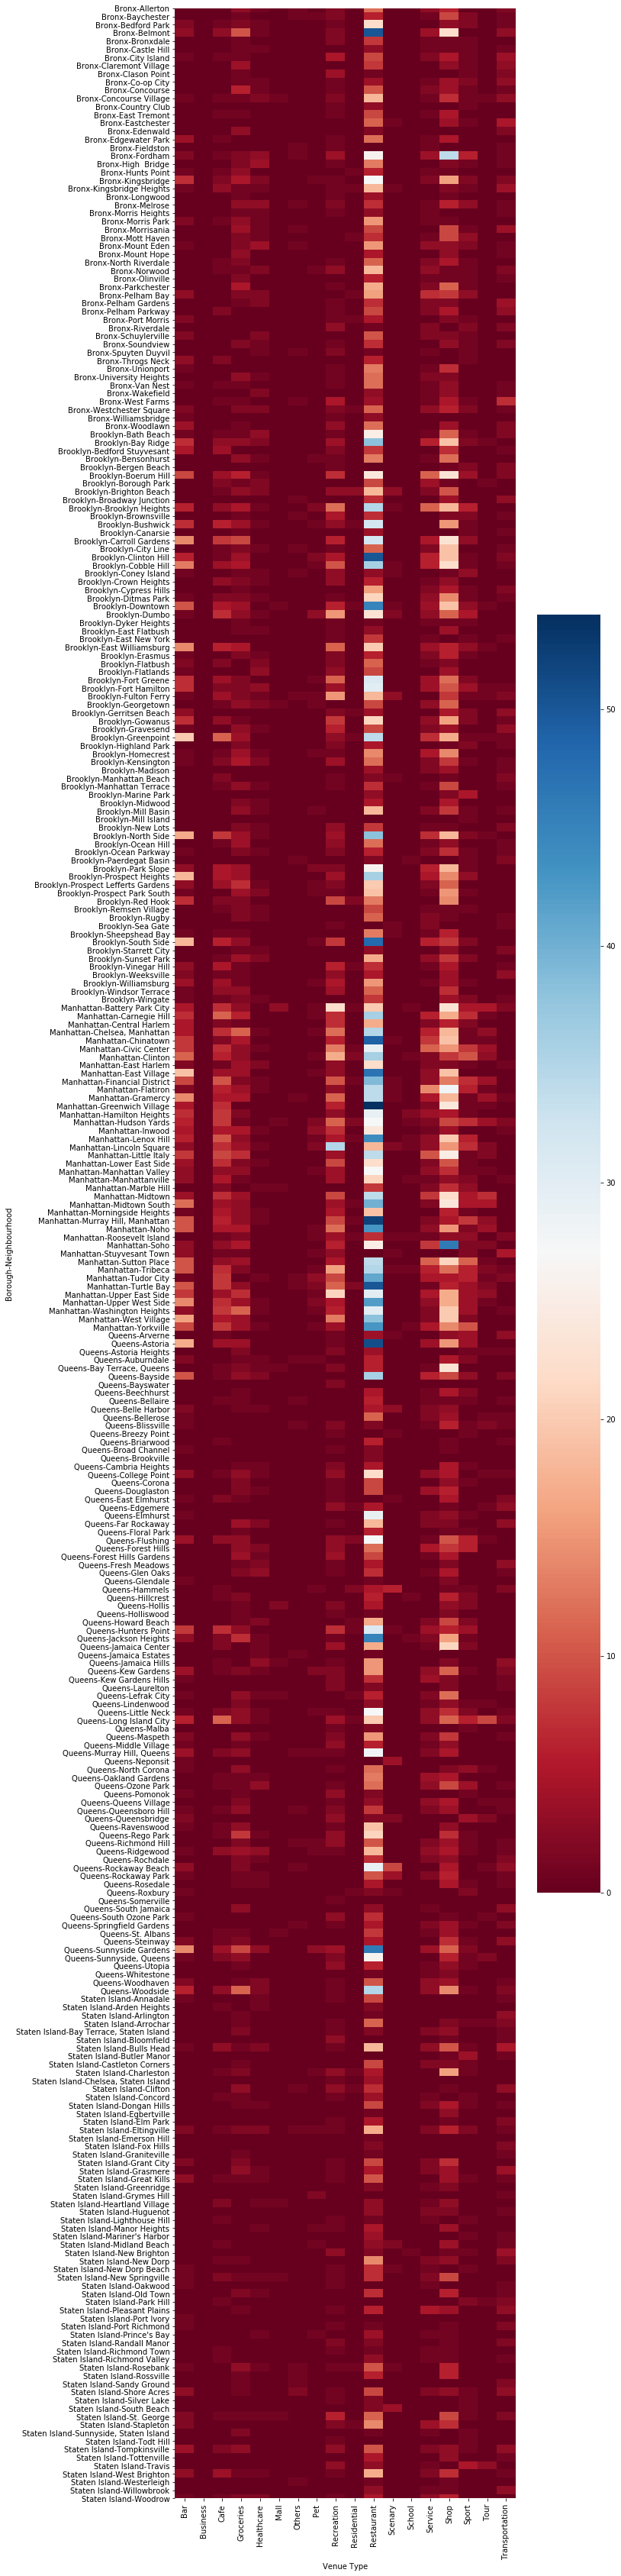

In [80]:
# Create a heatmap
plt.figure(figsize=(10,60))
sns.heatmap(heatmap_data, cmap="RdBu")

##### The Most Common Venues for Each Neighbourhood

In [81]:
grouped_cat = venues_NYC_cat.reset_index()

In [82]:
grouped_dummies = venues_NYC_dummies.groupby('Neighbourhood').sum()
#temp_dummies.reset_index(inplace=True)
grouped_dummies.head(5)

,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North 

In [83]:
def most_common_venues(row, top_num):
    """
    A function that selects the most common venues for each neighbourhood
    """
        
    row_categories = row
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:top_num]

top_num=10
indicators = ['st', 'nd', 'rd']

In [84]:
# define the columns for the new dataframe with top common venues
column = ['Neighbourhood']
for ind in np.arange(top_num):
    try:
        column.append('{}{} Most Common Category'.format(ind+1, indicators[ind]))
    except:
        column.append('{}th Most Common Category'.format(ind+1))

# create the new dataframe with top common venues
venues_NYC_cat_sorted = pd.DataFrame(columns = column)
venues_NYC_cat_sorted['Neighbourhood'] = grouped_cat['Neighbourhood']

venues_NYC_cat_sorted.head(1)

,Neighbourhood,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,Allerton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
for ind in np.arange(venues_NYC_cat.shape[0]):
    venues_NYC_cat_sorted.iloc[ind, 1:] = most_common_venues(venues_NYC_cat.iloc[ind,:], top_num)

venues_NYC_cat_sorted.head()

,Neighbourhood,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,Allerton,Restaurant,Shop,Groceries,Service,Recreation,Transportation,Others,Healthcare,Pet,Tour
1,Annadale,Restaurant,Transportation,Bar,Recreation,Healthcare,Tour,Pet,Residential,Service,Scenary
2,Arden Heights,Restaurant,Cafe,Healthcare,Residential,Tour,Transportation,Pet,Recreation,Service,Scenary
3,Arlington,Transportation,Restaurant,Groceries,School,Bar,Cafe,Shop,Mall,Sport,Others
4,Arrochar,Restaurant,Transportation,Shop,Sport,Tour,Groceries,Recreation,Bar,Cafe,Mall


In [86]:
# create the new dataframe with top common venues
venues_NYC_sorted = pd.DataFrame(columns = column)
venues_NYC_sorted['Neighbourhood'] = grouped_cat['Neighbourhood']

venues_NYC_sorted.head(1)


for ind in np.arange(grouped_dummies.shape[0]):
    venues_NYC_sorted.iloc[ind, 1:] = most_common_venues(grouped_dummies.iloc[ind,:], top_num)

venues_NYC_sorted.head()

,Neighbourhood,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,Allerton,Pizza Place,Deli / Bodega,Supermarket,Spa,Intersection,Check Cashing Service,Electronics Store,Martial Arts Dojo,Grocery Store,Chinese Restaurant
1,Annadale,Pizza Place,American Restaurant,Park,Sushi Restaurant,Train Station,Pharmacy,Diner,Restaurant,Food,Sports Bar
2,Arden Heights,Pharmacy,Deli / Bodega,Coffee Shop,Pizza Place,Yoga Studio,Fast Food Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit
3,Arlington,Bus Stop,Deli / Bodega,Grocery Store,Boat or Ferry,Yoga Studio,Filipino Restaurant,Event Space,Exhibit,Eye Doctor,Factory
4,Arrochar,Italian Restaurant,Bus Stop,Deli / Bodega,Pizza Place,Food Truck,Supermarket,Bagel Shop,Outdoors & Recreation,Mediterranean Restaurant,Athletics & Sports


##### Clustering
Apply K-means clustering on the dataframe to cluster the neighbourhood into 5 clusters

In [87]:
NYC_grouped = venues_NYC_dummies.groupby('Neighbourhood').mean().reset_index()
NYC_grouped_clustering = NYC_grouped.drop('Neighbourhood', axis=1)
NYC_grouped_clustering.head(2)

,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North 

In [88]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
k = 5

# run k-means clustering
kmeans = KMeans(n_clusters=k, random_state=0).fit(NYC_grouped_clustering)

# check cluster labels generated for each row in teh dataframe
kmeans.labels_[0:10]

array([2, 2, 4, 1, 4, 3, 3, 2, 3, 2], dtype=int32)

Create a new dataframe that includes the cluster as well as the top 10 venues for each neighbourhood

In [89]:
neighbourhoods_NYC.sort_values('Neighbourhood', ascending=True, inplace=True)
neighbourhoods_NYC.head(2)

,Borough,Neighbourhood,Latitude,Longitude
298,Bronx,Allerton,40.865788,-73.859319
215,Staten Island,Annadale,40.538114,-74.178549


In [90]:
venues_NYC_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [91]:
NYC_merged = pd.merge(neighbourhoods_NYC, venues_NYC_sorted, 
                      how='left', on='Neighbourhood')
NYC_merged.head(2)

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,Bronx,Allerton,40.865788,-73.859319,2.0,Pizza Place,Deli / Bodega,Supermarket,Spa,Intersection,Check Cashing Service,Electronics Store,Martial Arts Dojo,Grocery Store,Chinese Restaurant
1,Staten Island,Annadale,40.538114,-74.178549,2.0,Pizza Place,American Restaurant,Park,Sushi Restaurant,Train Station,Pharmacy,Diner,Restaurant,Food,Sports Bar


In [92]:
# replace NaN in Cluster Labels
NYC_merged['Cluster Labels'].replace(to_replace = np.nan, value=5, inplace=True)
NYC_merged.loc[NYC_merged['Cluster Labels']==5]

,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
136,Staten Island,Howland Hook,40.638433,-74.186223,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Visualize the resulting clusters

##### Examine Clusters
Cluster 1

In [93]:
NYC_cluster1= NYC_merged.loc[NYC_merged['Cluster Labels'] == 0]
print("There are {} neighbourhoods in Cluster 1".format(NYC_cluster1.shape[0]))
NYC_cluster1

There are 5 neighbourhoods in Cluster 1


,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
16,Queens,Bayswater,40.611322,-73.765968,0.0,Playground,Park,Yoga Studio,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm
57,Bronx,Clason Point,40.806551,-73.854144,0.0,Park,Bus Stop,Grocery Store,Pool,Boat or Ferry,South American Restaurant,Yoga Studio,Field,Exhibit,Eye Doctor
253,Queens,Somerville,40.597711,-73.796648,0.0,Park,Yoga Studio,Filipino Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm
260,Bronx,Spuyten Duyvil,40.881395,-73.917190,0.0,Park,Intersection,Bank,Pharmacy,Thai Restaurant,Tennis Stadium,Yoga Studio,Farmers Market,Event Service,Event Space
273,Staten Island,Todt Hill,40.597069,-74.111329,0.0,Trail,Park,Yoga Studio,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory


Cluster 2

In [94]:
NYC_cluster2= NYC_merged.loc[NYC_merged['Cluster Labels'] == 1]
print("There are {} neighbourhoods in Cluster 2".format(NYC_cluster2.shape[0]))
NYC_cluster2

There are 13 neighbourhoods in Cluster 2


,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
3,Staten Island,Arlington,40.635325,-74.165104,1.0,Bus Stop,Deli / Bodega,Grocery Store,Boat or Ferry,Yoga Studio,Filipino Restaurant,Event Space,Exhibit,Eye Doctor,Factory
27,Staten Island,Bloomfield,40.605779,-74.187256,1.0,Recreation Center,Park,Theme Park,Bus Stop,Discount Store,Filipino Restaurant,Event Space,Exhibit,Eye Doctor,Factory
108,Staten Island,Fox Hills,40.617311,-74.081740,1.0,Bus Stop,American Restaurant,Sandwich Place,Yoga Studio,Filipino Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory
117,Staten Island,Graniteville,40.620172,-74.153152,1.0,Bus Stop,Grocery Store,Sandwich Place,Yoga Studio,Field,Event Service,Event Space,Exhibit,Eye Doctor,Factory
119,Staten Island,Grasmere,40.598268,-74.076674,1.0,Bus Stop,Grocery Store,Bagel Shop,Japanese Restaurant,Vegetarian / Vegan Restaurant,Ice Cream Shop,Nail Salon,Park,Pharmacy,Deli / Bodega
125,Staten Island,Grymes Hill,40.624185,-74.087248,1.0,Dog Run,Bus Stop,Yoga Studio,Film Studio,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm
164,Brooklyn,Manhattan Beach,40.577914,-73.943537,1.0,Café,Bus Stop,Ice Cream Shop,Sandwich Place,Playground,Pizza Place,Beach,Exhibit,Eye Doctor,Field
191,Staten Island,New Brighton,40.640615,-74.087017,1.0,Bus Stop,Deli / Bodega,Park,Discount Store,Daycare,Playground,Bowling Alley,Field,Fast Food Restaurant,Farmers Market
202,Staten Island,Oakwood,40.558462,-74.121566,1.0,Bar,Bus Stop,Playground,Lawyer,Filipino Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory
209,Staten Island,Park Hill,40.609190,-74.080157,1.0,Bus Stop,Hotel,Coffee Shop,Gym / Fitness Center,Athletics & Sports,Filipino Restaurant,Event Space,Exhibit,Eye Doctor,Factory


Cluster 3

In [95]:
NYC_cluster3= NYC_merged.loc[NYC_merged['Cluster Labels'] == 2]
print("There are {} neighbourhoods in Cluster 3".format(NYC_cluster3.shape[0]))
NYC_cluster3

There are 135 neighbourhoods in Cluster 3


,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,Bronx,Allerton,40.865788,-73.859319,2.0,Pizza Place,Deli / Bodega,Supermarket,Spa,Intersection,Check Cashing Service,Electronics Store,Martial Arts Dojo,Grocery Store,Chinese Restaurant
1,Staten Island,Annadale,40.538114,-74.178549,2.0,Pizza Place,American Restaurant,Park,Sushi Restaurant,Train Station,Pharmacy,Diner,Restaurant,Food,Sports Bar
7,Queens,Astoria Heights,40.770317,-73.894680,2.0,Italian Restaurant,Food,Hostel,Bowling Alley,Pizza Place,Bakery,Playground,Plaza,Supermarket,Burger Joint
9,Brooklyn,Bath Beach,40.599519,-73.998752,2.0,Chinese Restaurant,Pharmacy,Pizza Place,Sushi Restaurant,Italian Restaurant,Fast Food Restaurant,Donut Shop,Bubble Tea Shop,Burger Joint,Peruvian Restaurant
13,Staten Island,"Bay Terrace, Staten Island",40.553988,-74.139166,2.0,Supermarket,Insurance Office,Donut Shop,Train Station,Sushi Restaurant,Plaza,Liquor Store,Shipping Store,Italian Restaurant,Salon / Barbershop
14,Bronx,Baychester,40.866858,-73.835798,2.0,Electronics Store,Donut Shop,Men's Store,Bank,Fast Food Restaurant,Sandwich Place,Pet Store,Baseball Field,Other Great Outdoors,Boat or Ferry
17,Bronx,Bedford Park,40.870185,-73.885512,2.0,Diner,Chinese Restaurant,Pizza Place,Mexican Restaurant,Supermarket,Deli / Bodega,Sandwich Place,Spanish Restaurant,Fried Chicken Joint,Baseball Field
19,Queens,Beechhurst,40.792781,-73.804365,2.0,Yoga Studio,Boutique,Gym / Fitness Center,Gym,Optical Shop,Donut Shop,Pizza Place,Dessert Shop,Deli / Bodega,Restaurant
22,Queens,Bellerose,40.728573,-73.720128,2.0,Pizza Place,Italian Restaurant,Chinese Restaurant,Seafood Restaurant,Diner,Flower Shop,Motel,Mobile Phone Shop,Bank,Salon / Barbershop
23,Bronx,Belmont,40.857277,-73.888452,2.0,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Liquor Store,Dessert Shop,Bank,Donut Shop,Mexican Restaurant,Fish Market


Cluster 4

In [96]:
NYC_cluster4= NYC_merged.loc[NYC_merged['Cluster Labels'] == 3]
print("There are {} neighbourhoods in Cluster 4".format(NYC_cluster4.shape[0]))
NYC_cluster4

There are 118 neighbourhoods in Cluster 4


,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
5,Queens,Arverne,40.589144,-73.791992,3.0,Surf Spot,Metro Station,Sandwich Place,Playground,Donut Shop,Beach,Pizza Place,Coffee Shop,Board Shop,Bus Stop
6,Queens,Astoria,40.768509,-73.915654,3.0,Bar,Middle Eastern Restaurant,Greek Restaurant,Hookah Bar,Seafood Restaurant,Pizza Place,Mediterranean Restaurant,Gym / Fitness Center,Gym,Grocery Store
8,Queens,Auburndale,40.761730,-73.791762,3.0,Pharmacy,Pet Store,Miscellaneous Shop,Athletics & Sports,Korean Restaurant,Hookah Bar,Toy / Game Store,Furniture / Home Store,Discount Store,Fast Food Restaurant
10,Manhattan,Battery Park City,40.711932,-74.016869,3.0,Coffee Shop,Park,Hotel,Gym,Shopping Mall,Women's Store,Memorial Site,BBQ Joint,Clothing Store,Grocery Store
11,Brooklyn,Bay Ridge,40.625801,-74.030621,3.0,Italian Restaurant,Pizza Place,Spa,American Restaurant,Bar,Cosmetics Shop,Greek Restaurant,Hookah Bar,Playground,Pharmacy
12,Queens,"Bay Terrace, Queens",40.782843,-73.776802,3.0,Clothing Store,Shoe Store,Lingerie Store,Cosmetics Shop,Donut Shop,American Restaurant,Women's Store,Kids Store,Mobile Phone Shop,Furniture / Home Store
15,Queens,Bayside,40.766041,-73.774274,3.0,Bar,Sushi Restaurant,Pizza Place,Indian Restaurant,American Restaurant,Chinese Restaurant,Spa,Mexican Restaurant,Italian Restaurant,Greek Restaurant
18,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,3.0,Deli / Bodega,Pizza Place,Bar,Coffee Shop,Café,Discount Store,Cocktail Bar,Park,BBQ Joint,New American Restaurant
25,Brooklyn,Bergen Beach,40.615150,-73.898556,3.0,Harbor / Marina,Baseball Field,Donut Shop,Playground,Athletics & Sports,Filipino Restaurant,Event Space,Exhibit,Eye Doctor,Factory
26,Queens,Blissville,40.737251,-73.932442,3.0,Donut Shop,Hotel,Intersection,Art Gallery,Sporting Goods Shop,Movie Theater,Skating Rink,Mattress Store,Clothing Store,Electronics Store


Cluster 5

In [97]:
NYC_cluster5= NYC_merged.loc[NYC_merged['Cluster Labels'] == 4]
print("There are {} neighbourhoods in Cluster 5".format(NYC_cluster5.shape[0]))
NYC_cluster5

There are 34 neighbourhoods in Cluster 5


,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
2,Staten Island,Arden Heights,40.549286,-74.185887,4.0,Pharmacy,Deli / Bodega,Coffee Shop,Pizza Place,Yoga Studio,Fast Food Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit
4,Staten Island,Arrochar,40.596313,-74.067124,4.0,Italian Restaurant,Bus Stop,Deli / Bodega,Pizza Place,Food Truck,Supermarket,Bagel Shop,Outdoors & Recreation,Mediterranean Restaurant,Athletics & Sports
20,Queens,Bellaire,40.733014,-73.738892,4.0,Deli / Bodega,Bus Station,Coffee Shop,Moving Target,Laundromat,Breakfast Spot,Greek Restaurant,Convenience Store,Grocery Store,Gym
21,Queens,Belle Harbor,40.576156,-73.854018,4.0,Beach,Spa,Deli / Bodega,Pub,Italian Restaurant,Boutique,Donut Shop,Mexican Restaurant,Bagel Shop,Bakery
31,Queens,Briarwood,40.710935,-73.811748,4.0,Deli / Bodega,Mexican Restaurant,Fast Food Restaurant,Bus Station,Coffee Shop,Arts & Crafts Store,Indian Restaurant,Falafel Restaurant,Farmers Market,Farm
33,Queens,Broad Channel,40.603027,-73.820055,4.0,Other Nightlife,Deli / Bodega,Sporting Goods Shop,Dive Bar,Pizza Place,Film Studio,Event Space,Exhibit,Eye Doctor,Factory
37,Queens,Brookville,40.660003,-73.751753,4.0,Deli / Bodega,Yoga Studio,Film Studio,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm
64,Staten Island,Concord,40.604473,-74.084024,4.0,Deli / Bodega,Gym / Fitness Center,Peruvian Restaurant,Park,Supermarket,Coffee Shop,Sandwich Place,Tattoo Parlor,Farmers Market,Event Service
81,Brooklyn,East New York,40.669926,-73.880699,4.0,Deli / Bodega,Food Truck,Plaza,Gym,Metro Station,Caribbean Restaurant,Spanish Restaurant,Pizza Place,Event Service,Food
88,Bronx,Edgewater Park,40.821986,-73.813885,4.0,Italian Restaurant,Deli / Bodega,Donut Shop,Pizza Place,Japanese Restaurant,Coffee Shop,Liquor Store,Bar,Park,Asian Restaurant


### Map the Neighbourhoods and Clusters

In [98]:
# import Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [99]:
# create map
map_clusters = folium.Map(location=[latitude,longitude], zoom_start=11, min_zoom=9, max_zoom=12)

# set color scheme for the clusters
x = np.arange(k+1)
ys = [i + x + (1*x)**2 for i in range(k+1)]
colors_array = cm.rainbow(np.linspace(0,1,len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, name, cluster in zip(NYC_merged['Latitude'], 
                                 NYC_merged['Longitude'],
                                 NYC_merged['Neighbourhood'],
                                 NYC_merged['Cluster Labels']):
    label = folium.Popup(str(name) + ' Cluster' + str(cluster), parse_html=True)
    folium.CircleMarker([lat,lon], radius=3, popup=label, 
                        color=rainbow[int(cluster)-1], fill=True, fill_color=rainbow[int(cluster)-1], fill_opacity=0.8).add_to(map_clusters)
    
map_clusters

In [100]:
venues_NYC['New Category'] = np.zeros(venues_NYC.shape[0])

for row in range(0,venues_NYC.shape[0]):
    if venues_NYC.loc[row, 'Venue Category'] in restaurants:
        venues_NYC.loc[row, 'New Category'] = 'Restaurant'
    elif venues_NYC.loc[row, 'Venue Category'] in bars:
        venues_NYC.loc[row, 'New Category'] = 'Bar'
    elif venues_NYC.loc[row, 'Venue Category'] in cafes:
        venues_NYC.loc[row, 'New Category'] = 'Cafe'
    elif venues_NYC.loc[row, 'Venue Category'] in groceries:
        venues_NYC.loc[row, 'New Category'] = 'Grocery'
    elif venues_NYC.loc[row, 'Venue Category'] in shops:
        venues_NYC.loc[row, 'New Category'] = 'Shop'
    elif venues_NYC.loc[row, 'Venue Category'] in malls:
        venues_NYC.loc[row, 'New Category'] = 'Mall'
    elif venues_NYC.loc[row, 'Venue Category'] in sports:
        venues_NYC.loc[row, 'New Category'] = 'Sport'
    elif venues_NYC.loc[row, 'Venue Category'] in schools:
        venues_NYC.loc[row, 'New Category'] = 'School'
    elif venues_NYC.loc[row, 'Venue Category'] in healthcare:
        venues_NYC.loc[row, 'New Category'] = 'Healthcare'
    elif venues_NYC.loc[row, 'Venue Category'] in services:
        venues_NYC.loc[row, 'New Category'] = 'Service'
    elif venues_NYC.loc[row, 'Venue Category'] in recreation:
        venues_NYC.loc[row, 'New Category'] = 'Recreation'
    elif venues_NYC.loc[row, 'Venue Category'] in pets:
        venues_NYC.loc[row, 'New Category'] = 'Pet'
    elif venues_NYC.loc[row, 'Venue Category'] in transportation:
        venues_NYC.loc[row, 'New Category'] = 'Transportation'
    elif venues_NYC.loc[row, 'Venue Category'] in tours:
        venues_NYC.loc[row, 'New Category'] = 'Tour'
    elif venues_NYC.loc[row, 'Venue Category'] in residential:
        venues_NYC.loc[row, 'New Category'] = 'Residential'
    elif venues_NYC.loc[row, 'Venue Category'] in business:
        venues_NYC.loc[row, 'New Category'] = 'Business'
    elif venues_NYC.loc[row, 'Venue Category'] in scenary:
        venues_NYC.loc[row, 'New Category'] = 'Scenary'
    else:
        venues_NYC.loc[row, 'New Category'] = 'Others'

venues_NYC.head()

,Neighbourhood,Latitude,Longitude,Venue,Venue Category,Venue Latitude,Venue Longitude,New Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,Dessert Shop,40.894123,-73.845892,Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,Pharmacy,40.896649,-73.844846,Healthcare
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,Ice Cream Shop,40.890487,-73.848568,Shop
3,Wakefield,40.894705,-73.847201,Walgreens,Pharmacy,40.896687,-73.844850,Healthcare
4,Wakefield,40.894705,-73.847201,Dunkin',Donut Shop,40.890459,-73.849089,Shop


In [101]:
# Assign map icon for each category

cat_item = ['Restaurant', 'Bar', 'Cafe', 'Grocery', 'Shop', 'Mall', 'Sport', 'School', 'Healthcare', 'Service', 'Recreation', 'Pet', 'Transportation', 'Tour', 'Residential', 'Business', 'Scenary', 'Others']
#Categories_url = []
#_url = '_url'
#for cat in cat_item:
#    Categories_url.append(cat + _url)
#Categories_url

url = ['https://image.flaticon.com/icons/svg/383/383662.svg',
    'https://image.flaticon.com/icons/svg/2597/2597420.svg',
    'https://image.flaticon.com/icons/svg/1676/1676955.svg',
    'https://image.flaticon.com/icons/svg/2605/2605723.svg',
    'https://image.flaticon.com/icons/svg/2611/2611076.svg',
    'https://image.flaticon.com/icons/svg/1495/1495159.svg',
    'https://image.flaticon.com/icons/svg/2622/2622372.svg',
    'https://image.flaticon.com/icons/svg/906/906175.svg',
    'https://image.flaticon.com/icons/svg/2622/2622367.svg',
    'https://image.flaticon.com/icons/svg/892/892926.svg',
    'https://image.flaticon.com/icons/svg/433/433102.svg',
    'https://image.flaticon.com/icons/svg/1530/1530908.svg',
    'https://image.flaticon.com/icons/svg/1515/1515539.svg',
    'https://image.flaticon.com/icons/svg/2599/2599840.svg',
    'https://image.flaticon.com/icons/svg/1647/1647748.svg',
    'https://image.flaticon.com/icons/svg/2617/2617923.svg',
    'https://image.flaticon.com/icons/svg/366/366918.svg',
    'https://image.flaticon.com/icons/svg/684/684809.svg']

In [102]:
url_df = pd.DataFrame(data=zip(cat_item, url), columns = ['Category','Icon URL'])

In [103]:
url_df.loc[url_df['Category'] == 'Bar']

,Category,Icon URL
1,Bar,https://image.flaticon.com/icons/svg/2597/2597...


In [104]:
url_df.loc[url_df['Category'] == 'Bar', 'Icon URL']

1    https://image.flaticon.com/icons/svg/2597/2597...
Name: Icon URL, dtype: object

In [105]:
# convert dataframe to dictionary in order to search values
url_dict = url_df.set_index('Category').to_dict()
url_dict = url_dict['Icon URL']

In [106]:
url_dict['Bar']

'https://image.flaticon.com/icons/svg/2597/2597420.svg'

In [107]:
venues_NYC1 = venues_NYC.iloc[5000:6001,:]

In [108]:
# add venue icons to the map
map_venues = folium.Map(location=[latitude,longitude], zoom_start=11, min_zoom=10, max_zoom=15)

for lat, lon, name, cat, ven_cat in zip(venues_NYC1['Venue Latitude'],
                                        venues_NYC1['Venue Longitude'],
                                        venues_NYC1['Venue'],
                                        venues_NYC1['New Category'],
                                        venues_NYC1['Venue Category']):
    icon_url = url_dict[cat]
    icon = folium.features.CustomIcon(icon_url, icon_size=(20,20))
    label = folium.Popup(str(name) + ', ' + str(ven_cat), parse_html=True)
    folium.Marker([lat,lon], icon=icon, popup=label).add_to(map_venues)

map_venues